 # Performance tests for full-text search

In [1]:
# Imports
import psycopg2
from random import randint
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import requests.auth
import json

try:
    import config  # Try to import attributes from config.py
except Exception as e:  # If no config.py, define Object with empty attributes
    print('Warning: No config.py found. ' +
          'Using empty values for non-provided connection attributes. ' +
          str(e))

    class Object(object):
        """Dummy class for config attributes."""
        pass

    config = Object()
    config.HOSTNAME = ''
    config.PORT = -1
    config.DBNAME = ''
    config.USERNAME = ''
    config.PASSWORD = ''


In [2]:
# Estabilishing connection to database
conn = psycopg2.connect(host=config.HOSTNAME,
                        port=config.PORT,
                        dbname=config.DBNAME,
                        user=config.USERNAME,
                        password=config.PASSWORD)
cur = conn.cursor()
cur.close()


In [3]:
# Preparing for N queries
times = []
labels = []

N = 100

# Using an excerpt from an interview in the dataset
search_string = 'Aí depois desse pan-americano, desse pan-americano de 91 a gente continuou se dedicando à conjunto de solo'


 ## Testing example of query plan

In [4]:
cur = conn.cursor()
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": search_string})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=212.03..212.03 rows=1 width=479) (actual rows=542 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery, 37)) DESC",)
('  Sort Method: quicksort  Memory: 1117kB',)
('  ->  Bitmap Heap Scan on interviews  (cost=208.00..212.02 rows=1 width=479) (actual rows=542 loops=1)',)
("        Recheck Cond: (tstext @@ '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery)",)
('        Heap Blocks: exact=411',)
('        ->  Bitmap Index Scan on interviews_idx_tstext  (cost=0.00..208.00 rows=1 width=0) (actual rows=542 loops=1)',)
("              Index Cond: (tstext @@ '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american

## Query 1: Using LIKE operator, without full-text search functionalities
Note: in this query, ranking by relevance is not available

In [5]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta
                        FROM interviews
                        WHERE text LIKE %(search_string)s;
    """, {"search_string": '%' + search_string + '%'})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Seq Scan on interviews  (cost=0.00..987.23 rows=1 width=475) (actual rows=542 loops=1)',)
("  Filter: (text ~~ '%Aí depois desse pan-americano, desse pan-americano de 91 a gente continuou se dedicando à conjunto de solo%'::text)",)
('  Rows Removed by Filter: 9476',)
('Planning Time: 0.068 ms',)
('Execution Time: 1924.713 ms',)
Execution time:  1924.713


In [6]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta
                        FROM interviews
                        WHERE text LIKE %(search_string)s;
    """, {"search_string": '%' + search_string + '%'})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador LIKE")


## Query 2: Using @@ operator, without tsvector index

In [10]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": search_string})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=987.24..987.24 rows=1 width=479) (actual rows=542 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery, 37)) DESC",)
('  Sort Method: quicksort  Memory: 1117kB',)
('  ->  Seq Scan on interviews  (cost=0.00..987.23 rows=1 width=479) (actual rows=542 loops=1)',)
("        Filter: (tstext @@ '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery)",)
('        Rows Removed by Filter: 9476',)
('Planning Time: 0.651 ms',)
('Execution Time: 540.825 ms',)
Execution time:  540.825


In [11]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=true')
cur.execute('drop index interviews_idx_tstext;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": search_string})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador @@")

## Query 3: Using @@ operator, forcing usage of tsvector index

In [13]:
cur = conn.cursor()
cur.execute('SET enable_seqscan=false')
cur.execute('alter table interviews drop constraint interviews_pkey cascade;')
cur.execute(
    """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": search_string})
result = cur.fetchall()
print(*result, sep='\n')
print('Execution time: ', float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()


('Sort  (cost=212.03..212.03 rows=1 width=479) (actual rows=542 loops=1)',)
("  Sort Key: (ts_rank_cd(tstext, '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery, 37)) DESC",)
('  Sort Method: quicksort  Memory: 1117kB',)
('  ->  Bitmap Heap Scan on interviews  (cost=208.00..212.02 rows=1 width=479) (actual rows=542 loops=1)',)
("        Recheck Cond: (tstext @@ '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''91'' & ''gent'' & ''continu'' & ''dedic'' & ''conjunt'' & ''sol'''::tsquery)",)
('        Heap Blocks: exact=411',)
('        ->  Bitmap Index Scan on interviews_idx_tstext  (cost=0.00..208.00 rows=1 width=0) (actual rows=542 loops=1)',)
("              Index Cond: (tstext @@ '''aí'' & ''dess'' & ''pan-american'' & ''pan'' & ''american'' & ''dess'' & ''pan-american

In [14]:
# Getting execution times
cur = conn.cursor()
cur.execute('SET enable_seqscan=false')
cur.execute('alter table interviews drop constraint interviews_pkey cascade;')
aux = []
for i in range(N):
    cur.execute(
        """EXPLAIN (ANALYZE TRUE, TIMING FALSE)
            SELECT id, text, questions, answers, meta,
                            ts_rank_cd(tstext,
                                       websearch_to_tsquery('portuguese',
                                                            %(search_string)s),
                                        1|4|32)
                                as rank
                        FROM interviews
                        WHERE tstext @@
                            websearch_to_tsquery('portuguese',
                                                 %(search_string)s)
                        ORDER BY rank DESC;
    """, {"search_string": search_string})
    result = cur.fetchall()
    aux.append(float(re.findall(r"\d+\.\d+", result[len(result)-1][0])[0]))
cur.close()
conn.rollback()
times.append(aux)
labels.append("Operador @@, com índice")


## Query 4: Using @@ operator, with access through the API

In [16]:
# creating API user
headers = {'Content-type': 'application/json'}
req = requests.post('http://localhost:5000/users',
                    auth=requests.auth.HTTPBasicAuth('api_admin', 'api_admin'),
                    data=json.dumps({
                        'new_username': 'test',
                        'new_password': 'test'
                    }),
                    headers=headers)
print('Status code: ', req.status_code)
print('JSON response: ', req.json())

# %%
# getting data from API
req = requests.get('http://localhost:5000/interviews/' + search_string,
                   auth=requests.auth.HTTPBasicAuth('test', 'test'))
print('Status code: ', req.status_code)
print('Elapsed time: ', req.elapsed.total_seconds() * 1000)


Status code:  409
JSON response:  {'message': 'Unique Violation. This user already exists.'}
Status code:  200
Elapsed time:  2999.3959999999997


In [17]:
aux = []
for i in range(N):
    req = requests.get('http://localhost:5000/interviews/' + search_string,
                       auth=requests.auth.HTTPBasicAuth('test', 'test'))
    aux.append(req.elapsed.total_seconds() * 1000)
times.append(aux)
labels.append("API")


## Graph comparison

In [20]:
print('Average access times (ms): ')
for i in range(len(times)):
    print(labels[i], '%.5f' % (sum(times[i]) / N), sep='\t\t')

Average access times (ms): 
LIKE operator		1889.19424
@@ operator		209.16244
@@ operator with index		67.41490
@@ operator, with index, API		2887.27622


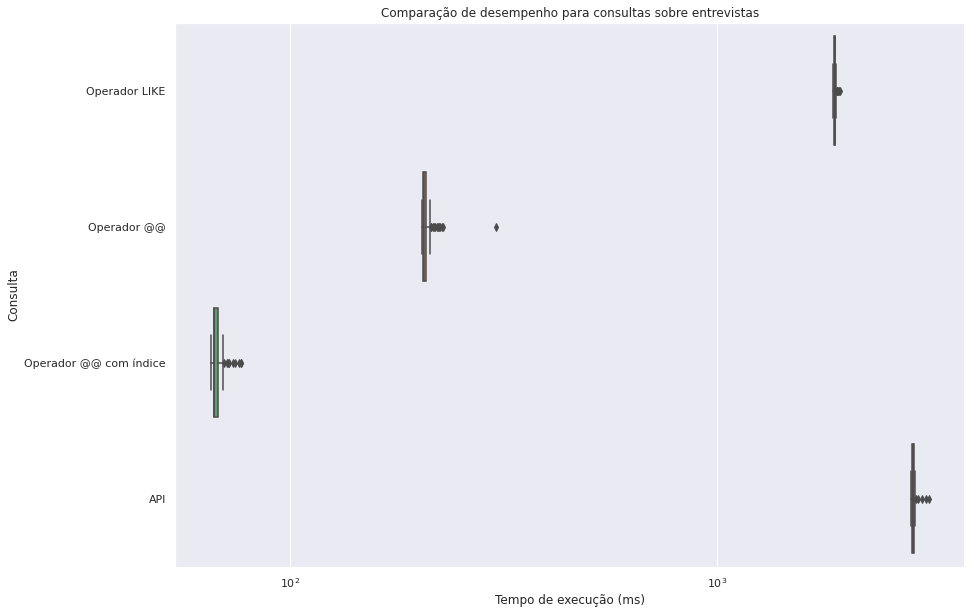

In [48]:
sns.set()
plt.figure(figsize=(10*1.4142, 10))
g = sns.boxplot(x=times, y=labels)
g.set(xscale="log")
plt.title("Comparação de desempenho para consultas sobre entrevistas")
plt.ylabel("Consulta")
plt.xlabel("Tempo de execução (ms)")
plt.plot()


[]

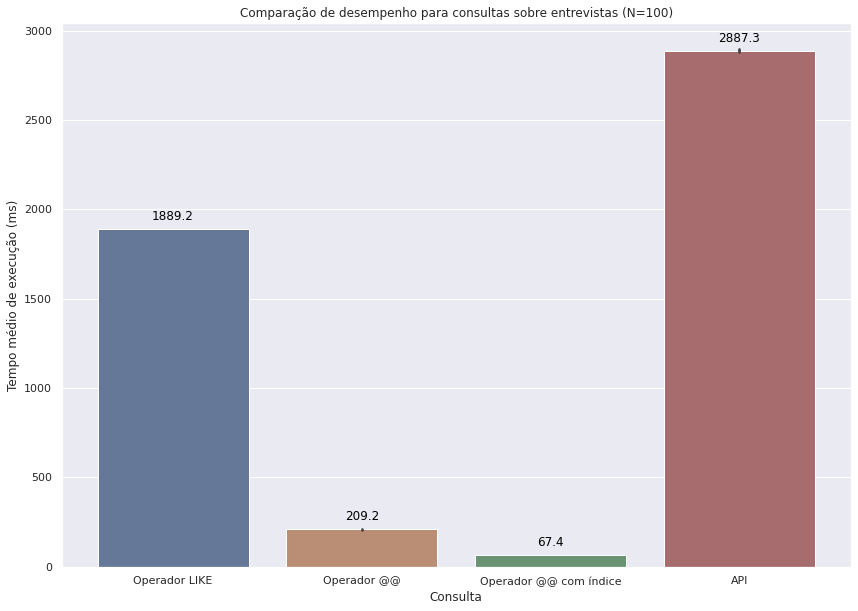

In [125]:
import numpy as np
import pandas as pd

arr = np.array(times).T
df = pd.DataFrame(arr, columns=labels)

sns.set()
plt.figure(figsize=(10*1.4142, 10))
#g = sns.barplot(data = times, units='ms')
g = sns.barplot(data=df, units='ms', capsize=0, saturation=0.5)
# g.set(yscale="log")
for idx, i in enumerate(df.mean()):
    g.text(idx, i+50, round(i, 1), color='black', ha="center")
plt.title("Comparação de desempenho para consultas sobre entrevistas (N=100)")
plt.xlabel("Consulta")
plt.ylabel("Tempo médio de execução (ms)")
plt.savefig('./perf.png')
plt.plot()